# CS188 Project 2 - Binary Classification Comparative Methods

For this project we're going to attempt a binary classification of a dataset using multiple methods and compare results. 

Our goals for this project will be to introduce you to several of the most common classification techniques, how to perform them and tweek parameters to optimize outcomes, how to produce and interpret results, and compare performance. You will be asked to analyze your findings and provide explanations for observed performance. 

Specifically you will be asked to classify whether a <b>patient is suffering from heart disease</b> based on a host of potential medical factors.

<b><u>DEFINITIONS</b></u>


<b> Binary Classification:</b>
In this case a complex dataset has an added 'target' label with one of two options. Your learning algorithm will try to assign one of these labels to the data.

<b> Supervised Learning:</b>
This data is fully supervised, which means it's been fully labeled and we can trust the veracity of the labeling.

## Background: The Dataset 

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. 

The dataset includes 14 columns. The information provided by each column is as follows:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (1 = male; 0 = female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>chol:</b> Cholestoral in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeak:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-4) colored by flourosopy</li>
    <li><b>thal:</b> categorical feature with values 0-3 (meaning not given) (original description: 1 = normal; 2 = fixed defect; 7 = reversable defect)</li>
    <li><b><u>sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>
    


## Loading Essentials and Helper Functions 

In [74]:
#Here are a set of libraries we imported to complete this assignment. 
#Feel free to use these or equivalent libraries for your implementation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold


from matplotlib import pyplot
import itertools

%matplotlib inline
import random 
  
random.seed(42) 

In [75]:
# Helper function allowing you to export a graph
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [76]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## [20 Points] Part 1. Load the Data and Analyze

Let's first load our dataset so we'll be able to work with it. (correct the relative path if your notebook is in a different directory than the csv file.)

In [77]:
def load_data(csv_path):
    return pd.read_csv(csv_path)
HEARTDISEASE_DATASET_PATH = "heartdisease.csv"
heartdisease = load_data(HEARTDISEASE_DATASET_PATH)

### Question 1.1 Now that our data is loaded, let's take a closer look at the dataset we're working with. Use the head method to display some of the rows so we can visualize the types of data fields we'll be working with, then use the describe method, along with any additional methods you'd like to call to better help you understand what you're working with and what issues you might face. 

In [78]:
heartdisease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,False
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,False
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,False
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,False
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,False


In [79]:
heartdisease.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000


In [80]:
heartdisease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
sick        303 non-null bool
dtypes: bool(1), float64(1), int64(12)
memory usage: 31.1 KB


In [81]:
heartdisease['age'].value_counts()

58    19
57    17
54    16
59    14
52    13
51    12
62    11
44    11
60    11
56    11
64    10
41    10
63     9
67     9
55     8
45     8
42     8
53     8
61     8
65     8
43     8
66     7
50     7
48     7
46     7
49     5
47     5
39     4
35     4
68     4
70     4
40     3
71     3
69     3
38     3
34     2
37     2
77     1
76     1
74     1
29     1
Name: age, dtype: int64

In [82]:
heartdisease['sex'].value_counts()

1    207
0     96
Name: sex, dtype: int64

In [83]:
heartdisease['cp'].value_counts()

0    143
2     87
1     50
3     23
Name: cp, dtype: int64

In [84]:
heartdisease['trestbps'].value_counts()

120    37
130    36
140    32
110    19
150    17
138    13
128    12
125    11
160    11
112     9
132     8
118     7
135     6
108     6
124     6
145     5
134     5
152     5
122     4
170     4
100     4
142     3
115     3
136     3
105     3
180     3
126     3
102     2
94      2
144     2
178     2
146     2
148     2
129     1
165     1
101     1
174     1
104     1
172     1
106     1
156     1
164     1
192     1
114     1
155     1
117     1
154     1
123     1
200     1
Name: trestbps, dtype: int64

In [85]:
heartdisease['chol'].value_counts()

234    6
204    6
197    6
269    5
212    5
254    5
226    4
243    4
240    4
239    4
233    4
177    4
282    4
211    4
219    3
230    3
283    3
263    3
245    3
288    3
199    3
258    3
256    3
236    3
246    3
231    3
220    3
303    3
229    3
274    3
      ..
326    1
340    1
215    1
341    1
342    1
353    1
354    1
360    1
394    1
407    1
306    1
305    1
300    1
293    1
217    1
224    1
237    1
241    1
242    1
409    1
252    1
257    1
259    1
262    1
276    1
278    1
281    1
284    1
290    1
564    1
Name: chol, Length: 152, dtype: int64

In [86]:
heartdisease['fbs'].value_counts()

0    258
1     45
Name: fbs, dtype: int64

In [87]:
heartdisease['restecg'].value_counts()

1    152
0    147
2      4
Name: restecg, dtype: int64

In [88]:
heartdisease['thalach'].value_counts()

162    11
160     9
163     9
173     8
152     8
125     7
132     7
150     7
172     7
143     7
144     7
156     6
169     6
158     6
140     6
142     6
178     5
161     5
154     5
165     5
168     5
174     5
170     5
182     5
179     5
157     5
147     5
145     4
131     4
130     4
       ..
181     2
180     2
106     1
97      1
99      1
113     1
95      1
90      1
88      1
117     1
202     1
118     1
177     1
194     1
192     1
190     1
188     1
187     1
185     1
184     1
167     1
121     1
195     1
137     1
134     1
129     1
128     1
127     1
124     1
71      1
Name: thalach, Length: 91, dtype: int64

In [89]:
heartdisease['exang'].value_counts()

0    204
1     99
Name: exang, dtype: int64

In [90]:
heartdisease['oldpeak'].value_counts()

0.0    99
1.2    17
0.6    14
1.0    14
0.8    13
1.4    13
0.2    12
1.6    11
1.8    10
0.4     9
2.0     9
0.1     7
2.6     6
2.8     6
1.9     5
1.5     5
0.5     5
3.0     5
2.2     4
3.6     4
2.4     3
3.4     3
4.0     3
0.9     3
0.3     3
2.3     2
4.2     2
1.1     2
2.5     2
3.2     2
6.2     1
2.1     1
4.4     1
1.3     1
3.1     1
0.7     1
5.6     1
3.8     1
2.9     1
3.5     1
Name: oldpeak, dtype: int64

In [91]:
heartdisease['slope'].value_counts()

2    142
1    140
0     21
Name: slope, dtype: int64

In [92]:
heartdisease['ca'].value_counts()

0    175
1     65
2     38
3     20
4      5
Name: ca, dtype: int64

In [93]:
heartdisease['thal'].value_counts()

2    166
3    117
1     18
0      2
Name: thal, dtype: int64

In [94]:
heartdisease['sick'].value_counts()

False    165
True     138
Name: sick, dtype: int64

### Question 1.2 Discuss your data preprocessing strategy. Are their any datafield types that are problemmatic and why? Will there be any null values you will have to impute and how do you intend to do so? Finally, for your numeric and categorical features, what if any, additional preprocessing steps will you take on those data elements?

- The boolean type of the sick feature is problematic because it contains categorical values and must be mapped to integers before it can be fed to the model.
- Note there were some typos in the descriptions of the columns for "ca" and "thal" that have been updated based on calling value_counts() on the individual columns, as well as minor typos in the column names.
- There are no null values to impute as can be seen by the call to heartdisease.info(), there are 303 total rows and each feature has 303 non-null values.

Categorical features (sex, cp, fbs, restecg, exang, slope, ca, thal, sick):
- For the categorical feature "sick", we need to convert it from a boolean variable with values "True" and "False" to a numeric variable with values 1 and 0 respectively. Then we need to drop the original column.
- TODO?: https://piazza.com/class/k54ozmtyrz85po?cid=160

Numerical features (age, trestbps, chol, thalach, oldpeak):
- TODO?: https://piazza.com/class/k54ozmtyrz85po?cid=160

### Question 1.3  Before we begin our analysis we need to fix the field(s) that will be problematic. Specifically convert our boolean sick variable into a binary numeric target variable (values of either '0' or '1'), and then drop the original sick datafield from the dataframe.

In [95]:
heartdisease['sick_num'] = heartdisease['sick'].astype(int)
heartdisease['sick_num'].value_counts()

0    165
1    138
Name: sick_num, dtype: int64

In [96]:
heartdisease = heartdisease.drop('sick', axis=1)
heartdisease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick_num
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,0


### Question 1.4 Now that we have a feel for the data-types for each of the variables, plot histograms of each field and attempt to ascertain how each variable performs (is it a binary, or limited selection, or does it follow a gradient? (Note: No need to describe each variable, but pick out a few you wish to highlight)

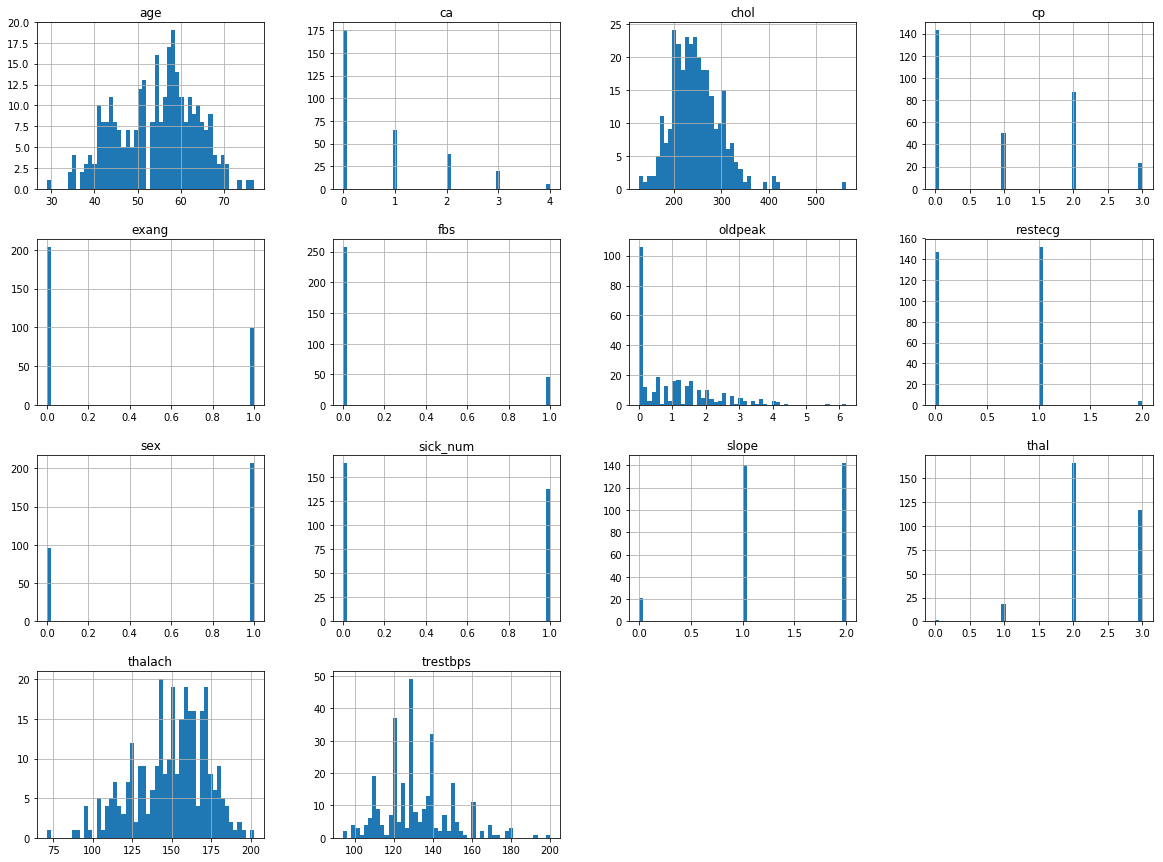

In [98]:
heartdisease.hist(bins=50, figsize=(20,15))
plt.show()

- age: gradient
- ca: gradient
- chol: gradient
- cp: limited selection
- exang: binary
- fbs: binary
- oldpeak: gradient
- restecg: limited selection
- sex: binary
- sick_num: binary
- slope: limited selection
- thal: limited selection
- thalach: gradient
- trestbps: gradient

### Question 1.5 We also want to make sure we are dealing with a balanced dataset. In this case, we want to confirm whether or not we have an equitable number of  sick and healthy individuals to ensure that our classifier will have a sufficiently balanced dataset to adequately classify the two. Plot a histogram specifically of the sick target, and conduct a count of the number of sick and healthy individuals and report on the results: 

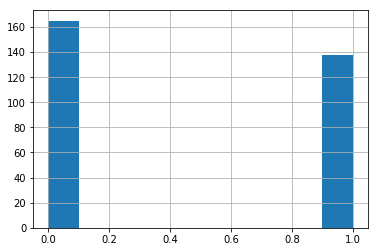

In [99]:
heartdisease['sick_num'].hist()
plt.show()

In [100]:
heartdisease['sick_num'].value_counts()

0    165
1    138
Name: sick_num, dtype: int64

Based on the "sick_num" feature, we have approximately (165/(165+138))*100 = 54% healthy individuals and 100-54 = 46% sick individuals. There is no absolute cutoff for balanced vs unbalanced data, and this split is quite close to a perfectly balanced 50-50 so most classifiers should be able to easily handle it.

### Question  1.6 Balanced datasets are important to ensure that classifiers train adequately and don't overfit, however arbitrary balancing of a dataset might introduce its own issues. Discuss some of the problems that might arise by artificially balancing a dataset.

- One technique for dealing with unbalanced datasets is upsampling or oversampling the minority class. A problem can arise when the oversampling is done before splitting into test and train datasets. This is because the exact same instances can be present in the test and train datasets, which can allow the model to memorize specific data points and cause overfitting and poor generalization to the test data.
- Another method is undersampling the majority class, which is a good option when we have a lot of data. A problem with this technique is that we could remove information that is valuable which may lead to underfitting and poor generalization to the test set.
- A third resampling technique is generating synthetic samples (one of the more popular approaches being SMOTE, which uses a nearest neighbors algorithm). This alleviates overfitting because similar instances are generated instead of exact replication of instances, and also doesn't result in loss of information. The problem that can arise with this method is that SMOTE doesn't consider that neighboring examples can be from other classes, which can increase the overlapping of classes and introduce additional noise.

### Question 1.9 Now that we have our dataframe prepared let's start analyzing our data. For this next question let's look at the correlations of our variables to our target value. First, map out the correlations between the values, and then discuss the relationships you observe. Do some research on the variables to understand why they may relate to the observed corellations. Intuitively, why do you think some variables correlate more highly than others (hint: one possible approach you can use the sns heatmap function to map the corr() method)?

In [101]:
corr_matrix = heartdisease.corr()
corr_matrix['sick_num'].sort_values(ascending=False)

sick_num    1.000000
exang       0.436757
oldpeak     0.430696
ca          0.391724
thal        0.344029
sex         0.280937
age         0.225439
trestbps    0.144931
chol        0.085239
fbs         0.028046
restecg    -0.137230
slope      -0.345877
thalach    -0.421741
cp         -0.433798
Name: sick_num, dtype: float64

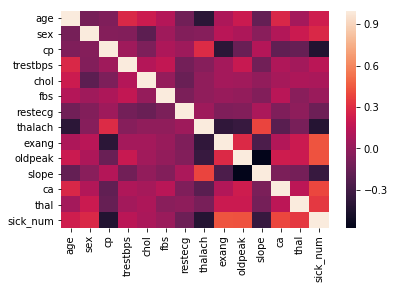

In [104]:
ax = sns.heatmap(heartdisease.corr())

- Based on the seaborn heatmap of the corr() function, we can see that sick_num has a strong positive correlation to exang/oldpeak, a moderate positive correlation to ca/thhal/sex/age, and no correlation to trestbps/chol/fbs/restecg. It also has a moderate negative correlation to slope and a strong negative correlation to thalach/cp.
- Based on web research of the variables, angina (exang) is an extremely common  symptom of coronary artery disease, a type of heart disease. In addition, exercise-induced ST depression (oldpeak) is considered an important metric by experts in the diagnosis of coronary disease.
- Intuitively, TODO

## [30 Points] Part 2. Prepare the Data 

Before running our various learning methods, we need to do some additional prep to finalize our data. Specifically you'll have to cut the classification target from the data that will be used to classify, and then you'll have to divide the dataset into training and testing cohorts.

Specifically, we're going to ask you to prepare 2 batches of data: 1. Will simply be the raw numeric data that hasn't gone through any additional pre-processing. The other, will be data that you pipeline using your own selected methods. We will then feed both of these datasets into a classifier to showcase just how important this step can be!

### Question 2.1 Save the target column as a separate array and then drop it from the dataframe. 

In [132]:
# Separate input features and target
y = heartdisease['sick_num']
X = heartdisease.drop('sick_num', axis=1)

### Question 2.2 First Create your 'Raw' unprocessed training data by dividing your dataframe into training and testing cohorts, with your training cohort consisting of 70% of your total dataframe (hint: use the train_test_split method) Output the resulting shapes of your training and testing samples to confirm that your split was successful.

In [133]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [134]:
X_train.shape

(212, 13)

In [135]:
y_train.shape

(212,)

In [136]:
X_test.shape

(91, 13)

In [137]:
y_test.shape

(91,)

### Question 2.3 Now create a pipeline to conduct any additional preparation of the data you would like. Output the resulting array to ensure it was processed correctly.

In [146]:
# TODO: Feature augmentation required?

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
])

numerical_features = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]

# Don't one hot encode these binary categorical features (already a present/absent designation): "exang", "fbs", "sick_num"
categorical_features = ["sex", "cp", "restecg", "slope", "thal"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(), categorical_features),
])
heartdisease_prepared = full_pipeline.fit_transform(heartdisease)

/Users/stewart/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/stewart/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/stewart/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHot

### Question 2.4 Now create a separate, processed training data set by dividing your processed dataframe into training and testing cohorts, using the same settings as Q2.2 (REMEMBER TO USE DIFFERENT TRAINING AND TESTING VARIABLES SO AS NOT TO OVERWRITE YOUR PREVIOUS DATA). Output the resulting shapes of your training and testing samples to confirm that your split was successful, and describe what differences there are between your two training datasets.

In [154]:
# Separate input features and target
y_prepared = heartdisease_prepared[:, 13]  # column index for sick_num
X_prepared = np.delete(heartdisease_prepared, 13, 1)

(303, 21)

In [155]:
# setting up testing and training sets
X_train_prepared, X_test_prepared, y_train_prepared, y_test_prepared = train_test_split(X_prepared, y_prepared, test_size=0.30, random_state=42)

In [156]:
X_train_prepared.shape

(212, 21)

In [157]:
y_train_prepared.shape

(212,)

In [158]:
X_test_prepared.shape

(91, 21)

In [159]:
y_test_prepared.shape

(91,)

While both the raw and processed training datasets contain 212 rows, the processed training dataset contains an additional 8 columns because of the one hot encoded features. This is because one hot encoding removes the original feature and a new binary feature is added for each unique integer value.

## [50 Points] Part 3. Learning Methods 

We're finally ready to actually begin classifying our data. To do so we'll employ multiple learning methods and compare result.

### Linear Decision Boundary Methods 

### SVM (Support Vector Machine)

A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

### Question 3.1.1 Implement a Support Vector Machine classifier on your RAW dataset. Review the [SVM Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) for how to implement a model. For this implementation you can simply use the default settings, but set probability = True.

In [160]:
# SVM
from sklearn.svm import SVC
svm = SVC(probability=True, gamma='auto')
svm.fit(X_train, y_train)
predicted = svm.predict(X_test)
score = svm.predict_proba(X_test)

### Question 3.1.2 Report the accuracy, precision, recall, F1 Score, and confusion matrix of the resulting model.

Accuracy:    0.560440
Precision:   1.000000
Recall:      0.024390
F1 Score:    0.047619
Confusion Matrix:



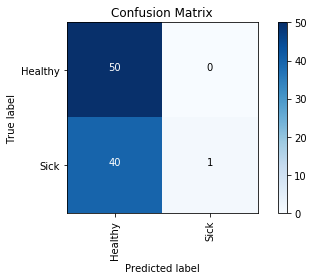

In [180]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("%-12s %f" % ('Accuracy:', accuracy_score(y_test, predicted)))
print("%-12s %f" % ('Precision:', precision_score(y_test, predicted)))
print("%-12s %f" % ('Recall:', recall_score(y_test, predicted)))
print("%-12s %f" % ('F1 Score:', f1_score(y_test, predicted)))
print("Confusion Matrix:\n")
draw_confusion_matrix(y_test, predicted, ["Healthy", "Sick"])

### Question 3.1.3 Discuss what each measure is reporting, why they are different, and why are each of these measures is significant. Explore why we might choose to evaluate the performance of differing models differently based on these factors. Try to give some specific examples of scenarios in which you might value one of these measures over the others.

### Metrics:
- Accuracy is a basic metric which simply reports the fraction of predictions the model got right, or the # of correct predictions/total # of predictions.
- Precision reports what proportion of positive identifications were actually correct. It is the ratio of the # of true positives/total # of positive predictions. This is important because a higher precision score corresponds to a low rate of false positives.
- Recall reports the ratio of # of true positives/all actual positive observations. This is the opposite of precision, because we're worried about false negatives and overlooking potential positives.
- F1 score reports the weighted average of precision and recall. Since it takes both false positives and false negatives into account, it is the best generalized measure when you want generally high performance minimizing both error types.
- A confusion matrix reports the magnitude and composition of errors, namely it is a matrix of the # of true positives, false negatives, false positives, and true negatives. This is important because it allows the visualization of the performance of an algorithm, and allows easy identification of confusion between classes (e.g., one class is commonly mislabeled as the other).

### Scenarios:
- Although high accuracy seems like a natural metric to strive for because of it's intuitiveness, it is not always the most important metric. Consider a model that has 99.9% accuracy, but the one false negative is classifying a terrorist as a non-terrorist or classifying someone with the coronavirus as not having the virus. The cost of a false negative is very high in these cases and so accuracy may be valued lower than other metrics. Recall would be a good metric to use to select the best model in this case.
- Consider email spam detection when the cost of a false positive is high because a user might lose important emails. In this case, precision might be valued over other metrics.
- If we assume the cost of a false positive in the terrorist scenario is also high (holding an innocent traveler up at the airport for hours), we'd want to prioritize F1 score to seek a balance between precision and recall. F1 score would also be useful in this case because there is an uneven class distribution (large number of actual negatives).

### Question 3.1.4 Plot a Receiver Operating Characteristic curve, or ROC curve, and describe what it is and what the results indicate

SVM Model Performance Results:



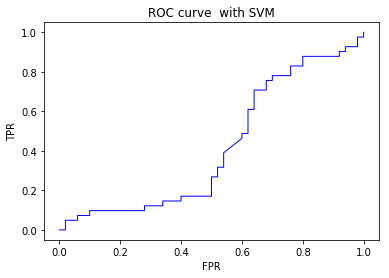

In [182]:
from sklearn.metrics import roc_curve

print("SVM Model Performance Results:\n")

fpr_svm, tpr_svm, thresholds = roc_curve(y_test, score[:, 1], pos_label=1)
pyplot.figure(1)
pyplot.plot(fpr_svm, tpr_svm, color='blue', lw=1)
pyplot.title("ROC curve  with SVM")
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
pyplot.show()

- The ROC curve is created by plotting the true positive rate (TPR) (aka recall) against the false positive rate (FPR) at various classification threshold settings. ROC curves give you a great indication for how likely your model will generalize. The ROC curve shows the tradeoff between sensitivity (or TPR) and specificity (1 - FPR).
- The results here indicate that our test is not very accurate and our classifier does not perform well. The more accurate a test and better performing a classifier the closer the ROC curve follows the left-hand border and then the top border of the ROC space. Our line is even below the 45-degree diagonal of the ROC space (indicating no predictive value). A random classifier is expected to give points lying along the diagonal (FPR = TPR) and ours does not even do that well.

### Question 3.1.5 Rerun, using the exact same settings, only this time use your processed data as inputs. 

In [183]:
# SVM
from sklearn.svm import SVC
svm = SVC(probability=True, gamma='auto')
svm.fit(X_train_prepared, y_train_prepared)
predicted_prepared = svm.predict(X_test_prepared)
score_prepared = svm.predict_proba(X_test_prepared)

### Question 3.1.6 Report the accuracy, precision, recall, F1 Score, confusion matrix, and plot the ROC Curve of the resulting model.

Accuracy:    0.989011
Precision:   0.977273
Recall:      1.000000
F1 Score:    0.988506
Confusion Matrix:



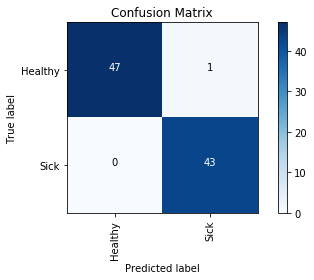

SVM Model Performance Results:



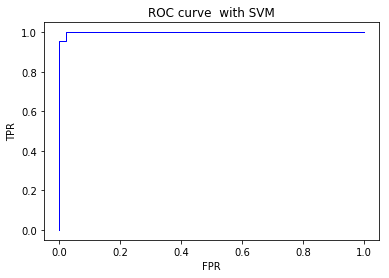

In [185]:
print("%-12s %f" % ('Accuracy:', accuracy_score(y_test_prepared, predicted_prepared)))
print("%-12s %f" % ('Precision:', precision_score(y_test_prepared, predicted_prepared)))
print("%-12s %f" % ('Recall:', recall_score(y_test_prepared, predicted_prepared)))
print("%-12s %f" % ('F1 Score:', f1_score(y_test_prepared, predicted_prepared)))
print("Confusion Matrix:\n")
draw_confusion_matrix(y_test_prepared, predicted_prepared, ["Healthy", "Sick"])

print("SVM Model Performance Results:\n")
fpr_svm_prepared, tpr_svm_prepared, thresholds_prepared = roc_curve(y_test_prepared, score_prepared[:, 1], pos_label=1)
pyplot.figure(1)
pyplot.plot(fpr_svm_prepared, tpr_svm_prepared, color='blue', lw=1)
pyplot.title("ROC curve  with SVM")
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
pyplot.show()

### Question 3.1.7 Hopefully you've noticed a dramatic change in performance. Discuss why you think your new data has had such a dramatic impact. 

We can see that our classifier performs dramatically better by the ROC curve being closer to the top left hand corner, a confusion matrix with only a single incorrect prediction, and accuracy/precision/recall/F1 score all much closer to 1. This can be attributed to scaling all numeric features as well as one hot encoding categorical features based on some general heuristics. Namely, we didn't one hot encode binary categorical features that already indicate a present/absent designation. Scaling numerical features ensures that data isn't distorted by values of different units and varying magnitudes. One hot encoding of limited selection categorical features prevents the classifier from associating a relative value to the feature when in fact the value is arbitrary. One hot encoding binary categorical features enables the classifier to treat both values as actual features when they are meaningful instead of simply the absence of the other. These preprocessing steps allowed our model to better understand the data and resulted in better performance.

### Question 3.1.8 Rerun your SVM, but now modify your model parameter kernel to equal 'linear'. Again report your Accuracy, Precision, Recall, F1 scores, and Confusion matrix and plot the new ROC curve.  

In [186]:
# SVM
from sklearn.svm import SVC
svm = SVC(probability=True, gamma='auto', kernel='linear')
svm.fit(X_train_prepared, y_train_prepared)
predicted_prepared_linear = svm.predict(X_test_prepared)
score_prepared_linear = svm.predict_proba(X_test_prepared)

Accuracy:    1.000000
Precision:   1.000000
Recall:      1.000000
F1 Score:    1.000000
Confusion Matrix:



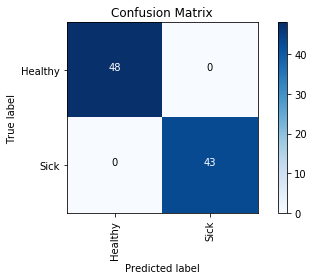

SVM Model Performance Results:



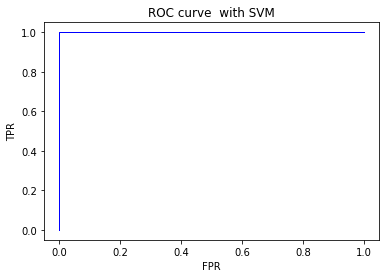

In [187]:
print("%-12s %f" % ('Accuracy:', accuracy_score(y_test_prepared, predicted_prepared_linear)))
print("%-12s %f" % ('Precision:', precision_score(y_test_prepared, predicted_prepared_linear)))
print("%-12s %f" % ('Recall:', recall_score(y_test_prepared, predicted_prepared_linear)))
print("%-12s %f" % ('F1 Score:', f1_score(y_test_prepared, predicted_prepared_linear)))
print("Confusion Matrix:\n")
draw_confusion_matrix(y_test_prepared, predicted_prepared_linear, ["Healthy", "Sick"])

print("SVM Model Performance Results:\n")
fpr_svm_prepared, tpr_svm_prepared, thresholds_prepared = roc_curve(y_test_prepared, score_prepared_linear[:, 1], pos_label=1)
pyplot.figure(1)
pyplot.plot(fpr_svm_prepared, tpr_svm_prepared, color='blue', lw=1)
pyplot.title("ROC curve  with SVM")
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
pyplot.show()

### Question 3.1.9 Explain the what the new results you've achieved mean. Read the documentation to understand what you've changed about your model and explain why changing that input parameter might impact the results in the manner you've observed.

The default kernel type for SVM that was used previously was a Radial Basis Function (RBF), which achieves linear splitting by increasing the dimensionality of the data and then splitting on that higher dimension. Changing the kernel type to linear causes the model to assume the current data is already linearly separable in its current dimensionality. Surprisingly, the model with the linear kernel slightly outperforms RBF (even though RBF generally performs better). This can happen when RBF overfits on training data that is pretty linearly separable. This indicates our data is not non-linearly separable and suggests that classifiers more optimized for linear classification might perform better than SVM on this dataset.

### Logistic Regression

Knowing that we're dealing with a linearly configured dataset, let's now try another classifier that's well known for handling linear models: Logistic Regression. Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.

### Question 3.2.1 Implement a Logistical Regression Classifier. Review the [Logistical Regression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for how to implement the model. For this initial model set the solver = 'sag' and max_iter= 10). Report on the same four metrics as the SVM and graph the resulting ROC curve.

In [188]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='sag', max_iter=10)
lr.fit(X_train_prepared, y_train_prepared)
predicted_prepared = lr.predict(X_test_prepared)
score_prepared = lr.predict_proba(X_test_prepared)

/Users/stewart/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy:    0.989011
Precision:   0.977273
Recall:      1.000000
F1 Score:    0.988506
Confusion Matrix:



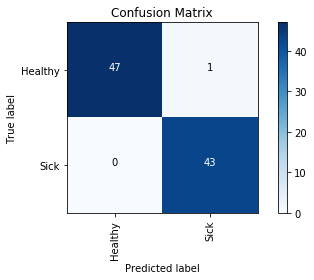

SVM Model Performance Results:



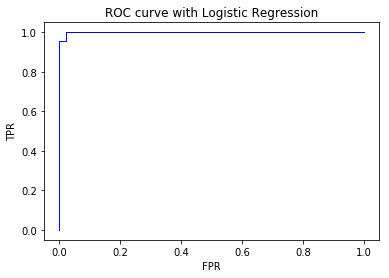

In [189]:
print("%-12s %f" % ('Accuracy:', accuracy_score(y_test_prepared, predicted_prepared)))
print("%-12s %f" % ('Precision:', precision_score(y_test_prepared, predicted_prepared)))
print("%-12s %f" % ('Recall:', recall_score(y_test_prepared, predicted_prepared)))
print("%-12s %f" % ('F1 Score:', f1_score(y_test_prepared, predicted_prepared)))
print("Confusion Matrix:\n")
draw_confusion_matrix(y_test_prepared, predicted_prepared, ["Healthy", "Sick"])

print("SVM Model Performance Results:\n")
fpr_lr_prepared, tpr_lr_prepared, thresholds_prepared = roc_curve(y_test_prepared, score_prepared[:, 1], pos_label=1)
pyplot.figure(1)
pyplot.plot(fpr_lr_prepared, tpr_lr_prepared, color='blue', lw=1)
pyplot.title("ROC curve with Logistic Regression")
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
pyplot.show()

### Question 3.2.2 Did you notice that when you ran the previous model you got the following warning: "ConvergenceWarning: The max_iter was reached which means the coef_ did not converge". Check the documentation and see if you can implement a fix for this problem, and again report your results.

In [141]:
# Logistic Regression


### Question 3.2.3 Explain what you changed, and why that produced an improved outcome. 

[Provide explanation here] 

### Question 3.2.4 Rerun your logistic classifier, but modify the penalty = 'none', solver='sag' and again report the results.

In [142]:
# Logistic Regression


### Question 3.2.5 Explain what what the penalty parameter is doing in this function, what the solver method is, and why this combination likely produced a more optimal outcome. 

[Provide explanation here] 

### Question 3.2.6 Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary, then what’s the difference between their ways to find this boundary?

[Provide Answer here:] 

### Clustering Approaches 

Let us now try a different approach to classification using a clustering algorithm. Specifically, we're going to be using K-Nearest Neighbor, one of the most popular clustering approaches. 

### K-Nearest Neighbor  

### Question 3.3.1 Implement a K-Nearest Neighbor algorithm on our data and report the results. For this initial implementation simply use the default settings. Refer to the [KNN Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for details on implementation. Report on the accuracy of the resulting model.

In [143]:
# k-Nearest Neighbors algorithm


### Question 3.3.2 For clustering algorithms, we use different measures to determine the effectiveness of the model. Specifically here, we're interested in the Homogeneity Score, Completeness Score, V-Measure, Adjusted Rand Score, and Adjusted Mutual Information. Calculate each score (hint review the SKlearn Metrics Clustering documentation for how to implement).

### Question 3.3.3 Explain what each score means and interpret the results for this particular model. 

[Input answer here] 

As we're beginning to see, the input parameters for your model can dramatically impact the performance of the model. How do you know which settings to choose? Studying the models and studying your datasets are critical as they can help you anticipate which models and settings are likely to produce optimal results. However sometimes that isn't enough, and a brute force method is necessary to determine which parameters to use. For this next question we'll attempt to optimize a parameter using a brute force approach. 

### Question 3.3.4 Parameter Optimization.  The KNN Algorithm includes an n_neighbors attribute that specifies how many neighbors to use when developing the cluster. (The default value is 5, which is what your previous model used.) Lets now try n values of: 1, 2, 3, 5, 10, 20, 50, and 100. Run your model for each value and report the 6 measures (5 clustering specific plus accuracy) for each. Report on which n value produces the best accuracy and V-Measure. (HINT leverage python's ability to loop to run through the array and generate results without needing to manually code each iteration).

[Describe optimal results here]

### Question 3.3.5 When are clustering algorithms most effective, and what do you think  explains the comparative results we achieved?  

[Input answer here] 